In [58]:
import typing 
import pandas 
import seaborn
import cltrier_lib


SEED: int = 1

In [59]:
post_ids: pandas.DataFrame = (
    pandas.read_csv("../data/interim/twitter.german.posts.csv", index_col=0)
    [["id"]]
)
post_ids

,id
130351,1640263711905423360
130373,1629096801503420416
130279,1632391902698827777
130454,1628328481456025600
130467,1618971719229915138
...,...
15440,1620120210748604416
15386,1618991725128880131
15426,1630893887404351492
15334,1622533832464285696


In [60]:
replies = (
    pandas.read_csv("../data/raw/twitter.german/GermanyReplies2023.csv", index_col=0)
    .merge(post_ids, left_on="conversation_id", right_on="id")
    .rename(columns={"id_x": "id"})
    # exclude tweets with urls
    .pipe(lambda _df: _df[~_df["text"].str.contains("https://")])
    # exclude tweets that are short than 32 characters
    .pipe(lambda _df: _df[_df["text"].str.len() > 32])
    [["id", "author_id", "conversation_id", "text", "created_at"]]
)
replies

,id,author_id,conversation_id,text,created_at
2,1615837811294507008,1577540347437129728,1615836681713897472,@Einschlag22's account is temporarily unavaila...,2023-01-18T22:25:29.000Z
4,1618931943554555905,1504903461158232066,1618175028264341509,@n_roettgen Dass die Ukraine nun endlich Leopa...,2023-01-27T11:20:28.000Z
6,1618428584498192386,1434176183277654017,1618175028264341509,"@n_roettgen Das ist der größte Blödsinn, den k...",2023-01-26T02:00:18.000Z
7,1618400276138033152,1220102923868344322,1618175028264341509,@n_roettgen Mit Angriffspanzer Krieg beenden? ...,2023-01-26T00:07:48.000Z
9,1615837824799973384,391144851,1615836681713897472,@n_roettgen Hoffen wir es mal!\nWenn Deutschla...,2023-01-18T22:25:32.000Z
...,...,...,...,...,...
170822,1609956263428870147,1295365631748055044,1609821802993442816,"@MalteKaufmann Schön wärs, wenn man erfahren k...",2023-01-02T16:54:19.000Z
170823,1614621374747656200,1481944130125246467,1614519432356958208,@MalteKaufmann Was lassen wir uns noch von der...,2023-01-15T13:51:48.000Z
170824,1609958744473112583,153000722,1609821802993442816,@MalteKaufmann Ich habe viele Videos vom Silve...,2023-01-02T17:04:10.000Z
170825,1620795823578812416,882160247594418177,1620339792121839618,@HerbrandMarkus @jamila_anna Lustig wie Du die...,2023-02-01T14:46:51.000Z


In [61]:
# calculate the distribution of user activity (number of posts)
user_activity_dist: pandas.Series = replies["author_id"].value_counts().describe(percentiles=[.25, .5, .75, .8, .85, .9, .95, .96, .97, .98, .99, .995])
user_activity_dist

count    48425.000000
mean         2.817078
std          3.899700
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
80%          4.000000
85%          5.000000
90%          6.000000
95%          9.000000
96%         11.000000
97%         12.000000
98%         15.000000
99%         19.000000
99.5%       25.000000
max        177.000000
Name: count, dtype: float64

In [62]:
sampled_replies: pandas.DataFrame = (
    replies
    [   
        # select only the 40% most active users
        replies["author_id"].isin(
            list((replies["author_id"].value_counts() > user_activity_dist.loc["99.5%"]).pipe(lambda _s : _s[_s]).index)
        )
    ]
    .groupby("author_id")
    # sample by number of least active 40%' user posts
    .sample(n=int(user_activity_dist.loc["99.5%"]), random_state=SEED)
)

len(sampled_replies), len(sampled_replies["author_id"].unique())

(5775, 231)

In [63]:
sampled_replies

,id,author_id,conversation_id,text,created_at
72594,1631783632519016449,15891726,1631341994235633669,@christianduerr Sie haben wirklich keine Ahnung.,2023-03-03T22:28:29.000Z
127493,1646771345164828672,15891726,1646766528895897600,@StBrandner Nö. Die liegt permanent falsch.,2023-04-14T07:04:18.000Z
79088,1637168335048646658,15891726,1637145132397916161,@f_schaeffler Dann bauen wir doch da ein KKW hin.,2023-03-18T19:05:22.000Z
114121,1617115491868512256,15891726,1616701560431542272,@RKiesewetter @DiedasSchaffers Ok. Stimmt. Sie...,2023-01-22T11:02:32.000Z
125733,1635196482180780033,15891726,1634905930595991554,@katjadler Ja. Aber Grundsätzlich verstehen Si...,2023-03-13T08:29:56.000Z
...,...,...,...,...,...
94973,1650046072499195904,1633533791900663809,1650041581120942084,@MarcusFaber Wir? Was hast Du denn erreicht? C...,2023-04-23T07:56:54.000Z
102853,1633739862342881280,1633533791900663809,1633382997389983744,@nyke_slawik Madame Slawik. Frauentag = Frauen...,2023-03-09T08:01:51.000Z
75614,1647545875923607553,1633533791900663809,1647368824985886722,"@KonstantinNotz Polen, Finnland, Belgien, Fran...",2023-04-16T10:22:01.000Z
94441,1634333263220076549,1633533791900663809,1634268513849286656,"@MarcusFaber Die Schweiz....Respekt davor, sic...",2023-03-10T23:19:49.000Z


In [69]:
(
    sampled_replies
    .assign(text=sampled_replies["text"].replace("\n"," ", regex=True))
    .to_csv("../data/interim/twitter.german.replies.csv")
)

In [65]:
classified_data = pandas.json_normalize(cltrier_lib.classify.Pipeline()(list(sampled_replies["text"]), threshold=0.0))
classified_data

,sample,results.topics.arts_&_culture,results.topics.business_&_entrepreneurs,results.topics.celebrity_&_pop_culture,results.topics.diaries_&_daily_life,results.topics.family,results.topics.fashion_&_style,results.topics.film_tv_&_video,results.topics.fitness_&_health,results.topics.food_&_dining,...,results.emotions.trust,results.sentiment.negative,results.sentiment.neutral,results.sentiment.positive,results.irony.non_irony,results.irony.irony,results.offensive.non-offensive,results.offensive.offensive,results.hate.NOT-HATE,results.hate.HATE
0,@christianduerr Sie haben wirklich keine Ahnung.,0.056676,0.005623,0.040536,0.349451,0.005903,0.001897,0.020741,0.001954,0.002040,...,0.019428,0.286341,0.794928,0.324692,0.761355,0.360660,0.709429,0.315027,0.933737,0.069417
1,@StBrandner Nö. Die liegt permanent falsch.,0.044308,0.017377,0.072307,0.142930,0.001647,0.006984,0.017336,0.002312,0.000797,...,0.011174,0.448532,0.739165,0.212625,0.789115,0.331196,0.694744,0.323877,0.905216,0.095373
2,@f_schaeffler Dann bauen wir doch da ein KKW hin.,0.055492,0.007126,0.024760,0.176852,0.003428,0.001976,0.020747,0.001953,0.000989,...,0.012167,0.252968,0.807421,0.341275,0.853751,0.261926,0.713625,0.307691,0.953836,0.048718
3,@RKiesewetter @DiedasSchaffers Ok. Stimmt. Sie...,0.027059,0.008521,0.028178,0.191422,0.002577,0.001983,0.033779,0.002202,0.001353,...,0.022058,0.197009,0.761428,0.479936,0.832033,0.284218,0.756586,0.258505,0.930236,0.072442
4,@katjadler Ja. Aber Grundsätzlich verstehen Si...,0.042991,0.004884,0.178280,0.177300,0.008214,0.001945,0.092979,0.003871,0.001673,...,0.026890,0.237946,0.800177,0.358688,0.746598,0.379806,0.724606,0.295501,0.916505,0.083523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5770,@MarcusFaber Wir? Was hast Du denn erreicht? C...,0.037239,0.013594,0.315934,0.214226,0.002731,0.028702,0.103098,0.003127,0.001557,...,0.019393,0.133554,0.808437,0.599155,0.881991,0.240165,0.706352,0.288040,0.953824,0.054047
5771,@nyke_slawik Madame Slawik. Frauentag = Frauen...,0.136066,0.009566,0.035357,0.407074,0.006616,0.005575,0.040911,0.001943,0.003406,...,0.025115,0.214548,0.810345,0.417663,0.805715,0.290384,0.668582,0.340390,0.962625,0.044199
5772,"@KonstantinNotz Polen, Finnland, Belgien, Fran...",0.015164,0.030019,0.020059,0.080115,0.002469,0.001849,0.007116,0.004411,0.003752,...,0.030068,0.326123,0.845865,0.214520,0.850828,0.231564,0.677409,0.320589,0.915199,0.080474
5773,"@MarcusFaber Die Schweiz....Respekt davor, sic...",0.013280,0.008147,0.041306,0.036268,0.001326,0.002107,0.029473,0.001135,0.000827,...,0.036944,0.276752,0.786658,0.315698,0.696521,0.418274,0.681183,0.319154,0.932326,0.076125


<Axes: xlabel='value', ylabel='variable'>

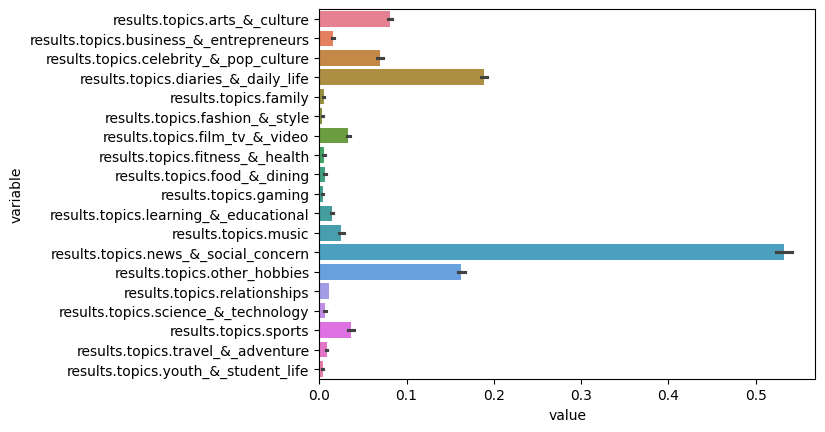

In [66]:
seaborn.barplot(
    classified_data.filter(like=".topics.").melt(),
    x="value", y="variable", hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

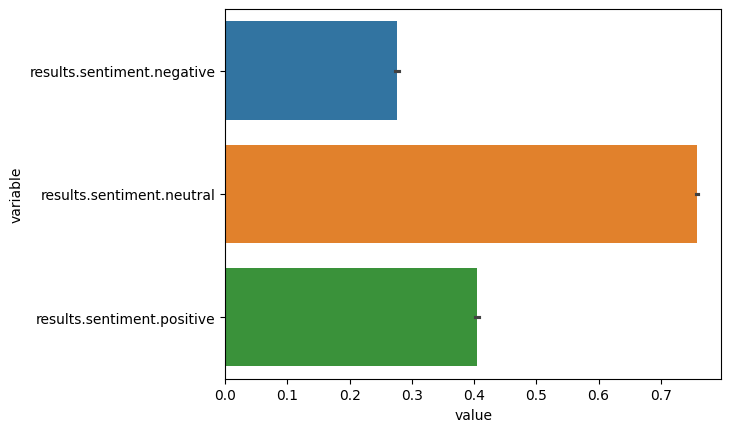

In [67]:
seaborn.barplot(
    classified_data.filter(like=".sentiment.").melt(),
    x="value", y="variable", hue="variable",
)

<Axes: xlabel='value', ylabel='variable'>

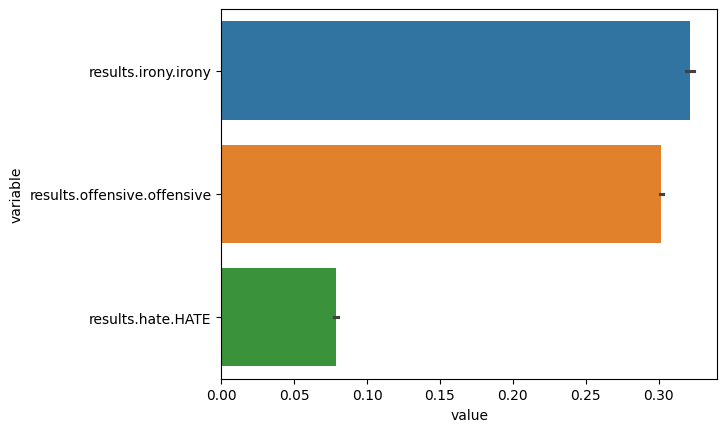

In [68]:
seaborn.barplot(
    classified_data.filter(regex="irony\.irony|offensive\.offensive|hate\.HATE").melt(),
    x="value", y="variable", hue="variable",
)